In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
tf.config.experimental.list_logical_devices()

2024-06-07 21:36:28.792030: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-07 21:36:28.846936: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-07 21:36:28.847149: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-07 21:36:28.847857: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the app

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

# Load Data

Found 1300 files belonging to 25 classes.


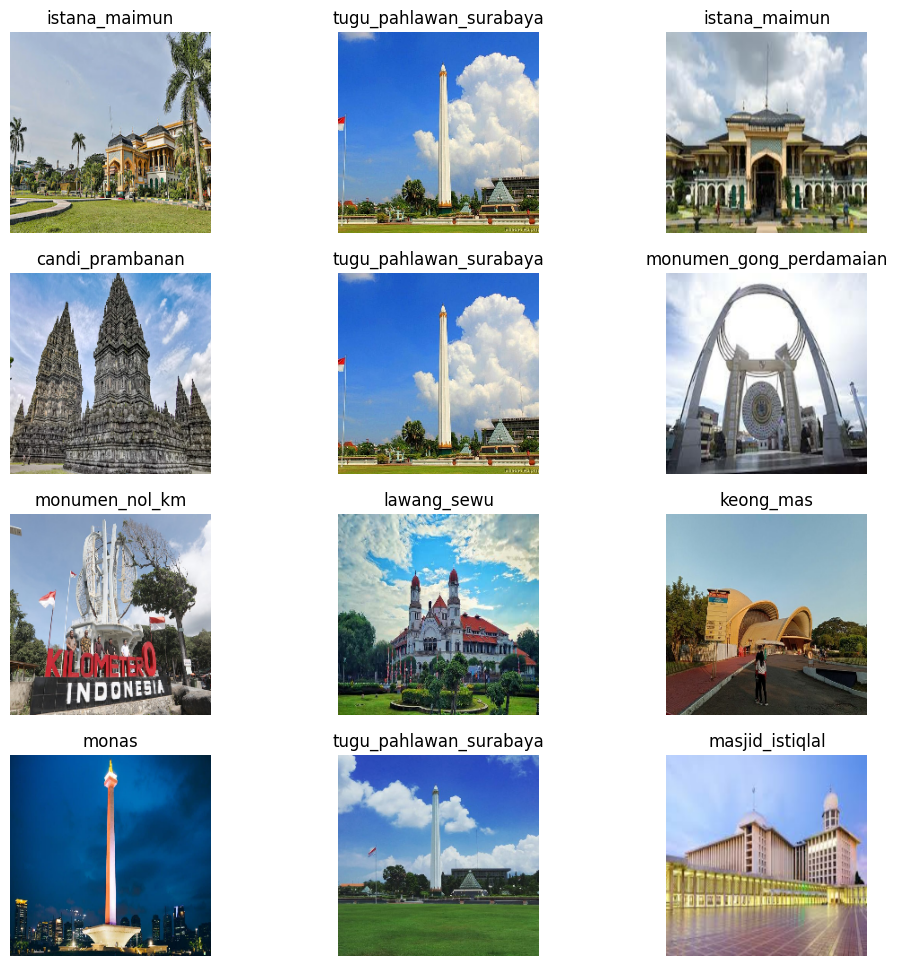

In [3]:
path_data = "./data-test/"

IMG_SIZE = 224
BATCH_SIZE = 12

data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=path_data,
    shuffle=True,
#     color_mode="grayscale",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
)

classes=data.class_names

plt.figure(figsize=(12, 12))
for img_batch, label_batch in data.take(1):
    for i in range(12):
        plt.subplot(4, 3, i+1)
        plt.title(f"{classes[label_batch[i]]}")
        plt.axis("Off")
        plt.imshow(img_batch[i].numpy().astype("int"), cmap='gray');

# Data Preprocessing

## Data Splitting

In [4]:
len_data=len(data)

# Shuffle data
data=data.shuffle(buffer_size=10000, seed=42)

train_size=int(len_data*0.85)
# val_size=int(len_data*0.7)

train_data=data.take(train_size)
val_data=data.skip(train_size)
# test_data=data.skip(train_size).skip(val_size)

print(f"""Length of data in each batch
ori data: {len_data}
train data: {len(train_data)}
val data: {len(val_data)}
""")

Length of data in each batch
ori data: 109
train data: 92
val data: 17



## Data Augmentation

In [5]:
# resize_and_rescale = tf.keras.Sequential([
#     tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
#     tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255.0),
# ])

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(.2),
#     tf.keras.layers.experimental.preprocessing.RandomZoom(.2, .3),
])

# Creating the model - DenseNet121 

In [6]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from utils import *

LABELS = sorted(['benteng_vredeburg',
 'candi_borobudur',
 'candi_prambanan',
 'garuda_wisnu_kencana',
 'gedung_sate',
 'istana_maimun',
 'jam_gadang',
 'keong_mas',
 'keraton_jogja',
 'kota_tua',
 'lawang_sewu',
 'masjid_istiqlal',
 'masjid_menara_kudus',
 'masjid_raya_baiturrahman',
 'menara_siger_lampung',
 'monas',
 'monumen_bandung_lautan_api',
 'monumen_gong_perdamaian',
 'monumen_nol_km',
 'monumen_simpang_lima_gumul',
 'patung_ikan_surabaya',
 'patung_yesus_memberkati',
 'tugu_jogja',
 'tugu_khatulistiwa',
 'tugu_pahlawan_surabaya'])

LABELS

['benteng_vredeburg',
 'candi_borobudur',
 'candi_prambanan',
 'garuda_wisnu_kencana',
 'gedung_sate',
 'istana_maimun',
 'jam_gadang',
 'keong_mas',
 'keraton_jogja',
 'kota_tua',
 'lawang_sewu',
 'masjid_istiqlal',
 'masjid_menara_kudus',
 'masjid_raya_baiturrahman',
 'menara_siger_lampung',
 'monas',
 'monumen_bandung_lautan_api',
 'monumen_gong_perdamaian',
 'monumen_nol_km',
 'monumen_simpang_lima_gumul',
 'patung_ikan_surabaya',
 'patung_yesus_memberkati',
 'tugu_jogja',
 'tugu_khatulistiwa',
 'tugu_pahlawan_surabaya']

## Model 3 - Frozen Weights

In [7]:
img_shape = (IMG_SIZE, IMG_SIZE, 3)
base_model = DenseNet121(
    input_shape=img_shape,
    weights="imagenet",
    include_top=False,
    classes=25,
    classifier_activation="softmax"
)

img_shape

(224, 224, 3)

In [8]:
inputs = tf.keras.Input(shape=img_shape)
x = data_augmentation(inputs)
x = base_model(x)
x = layers.AveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dropout(.1)(x)
x = layers.Dense(128, activation="relu")(x)
output = layers.Dense(25, activation="softmax")(x)

model_3 = Model(inputs=inputs, outputs=output, name="model_3_DenseNet121")

for layer in base_model.layers:
    layer.trainable = False

model_3.summary()

Model: "model_3_DenseNet121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 average_pooling2d (AverageP  (None, 3, 3, 1024)       0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dropout (Dropout)           (None, 9216)              0         
                                               

In [9]:
for i, l in enumerate(base_model.layers):
    print(i, l.name, l.trainable)

0 input_1 False
1 zero_padding2d False
2 conv1/conv False
3 conv1/bn False
4 conv1/relu False
5 zero_padding2d_1 False
6 pool1 False
7 conv2_block1_0_bn False
8 conv2_block1_0_relu False
9 conv2_block1_1_conv False
10 conv2_block1_1_bn False
11 conv2_block1_1_relu False
12 conv2_block1_2_conv False
13 conv2_block1_concat False
14 conv2_block2_0_bn False
15 conv2_block2_0_relu False
16 conv2_block2_1_conv False
17 conv2_block2_1_bn False
18 conv2_block2_1_relu False
19 conv2_block2_2_conv False
20 conv2_block2_concat False
21 conv2_block3_0_bn False
22 conv2_block3_0_relu False
23 conv2_block3_1_conv False
24 conv2_block3_1_bn False
25 conv2_block3_1_relu False
26 conv2_block3_2_conv False
27 conv2_block3_concat False
28 conv2_block4_0_bn False
29 conv2_block4_0_relu False
30 conv2_block4_1_conv False
31 conv2_block4_1_bn False
32 conv2_block4_1_relu False
33 conv2_block4_2_conv False
34 conv2_block4_concat False
35 conv2_block5_0_bn False
36 conv2_block5_0_relu False
37 conv2_block5_1_

In [10]:
model_3.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics=['accuracy'])

In [11]:
%%time
history_3 = model_3.fit(
    train_data,
    epochs=50,
    validation_data=val_data,
)

Epoch 1/50


2024-06-07 21:36:55.147225: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400


92/92 [==============================] - 24s 142ms/step - loss: 5.6779 - accuracy: 0.0502 - val_loss: 3.2194 - val_accuracy: 0.0490
Epoch 2/50
92/92 [==============================] - 9s 87ms/step - loss: 3.2196 - accuracy: 0.0374 - val_loss: 3.2191 - val_accuracy: 0.0490
Epoch 3/50
92/92 [==============================] - 9s 87ms/step - loss: 3.2192 - accuracy: 0.0417 - val_loss: 3.2188 - val_accuracy: 0.0459
Epoch 4/50
92/92 [==============================] - 10s 89ms/step - loss: 3.2199 - accuracy: 0.0292 - val_loss: 3.2175 - val_accuracy: 0.0510
Epoch 5/50
92/92 [==============================] - 10s 92ms/step - loss: 3.2204 - accuracy: 0.0374 - val_loss: 3.2171 - val_accuracy: 0.0343
Epoch 6/50
92/92 [==============================] - 10s 91ms/step - loss: 3.2191 - accuracy: 0.0420 - val_loss: 3.2129 - val_accuracy: 0.0408
Epoch 7/50
92/92 [==============================] - 10s 93ms/step - loss: 3.2068 - accuracy: 0.0401 - val_loss: 3.2066 - val_accuracy: 0.0612
Epoch 8/50
92/92 [

In [14]:
model_3.save("history/model_DenseNet121_v1.h5")

## Plot history of Model 3

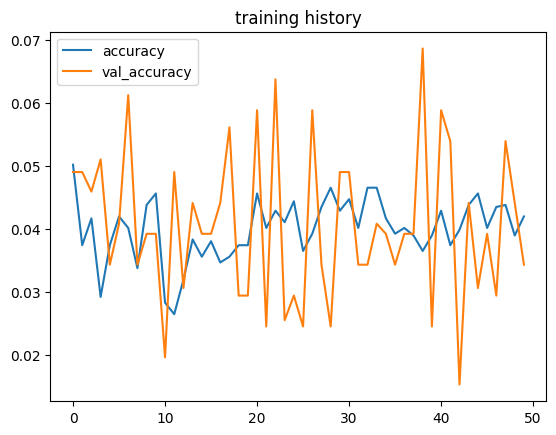

In [15]:
plot_history(model_history=history_3, seq_1="accuracy", seq_2="val_accuracy")

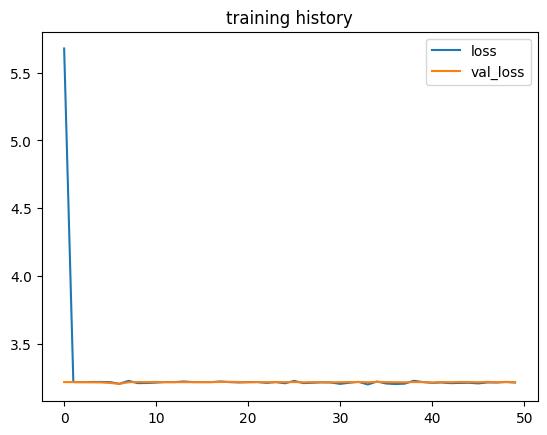

In [16]:
plot_history(model_history=history_3, seq_1="loss", seq_2="val_loss")

## Test model 3

In [17]:
list_new_img = os.listdir("./data-predict-on-new-img/")

def test_model(model, labels=LABELS):
    for x in list_new_img:
        predict_img(
            os.path.join("./data-predict-on-new-img", x), 
            model, 
            width=IMG_SIZE, 
            height=IMG_SIZE, 
            labels=LABELS
       )

1/1 [==============================] - 5s 5s/step


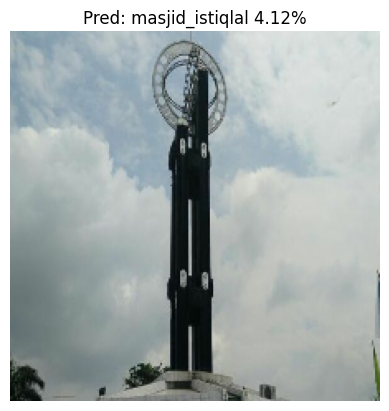

1/1 [==============================] - 0s 24ms/step


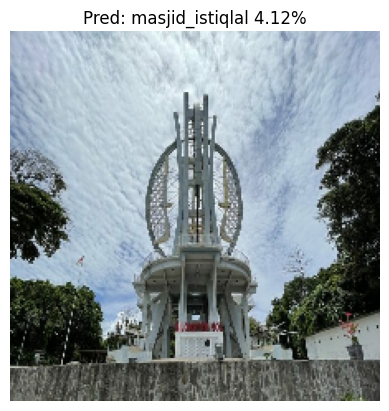

1/1 [==============================] - 0s 20ms/step


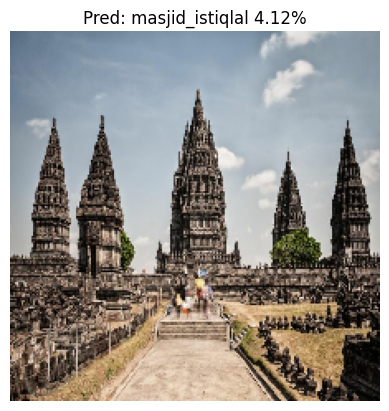

1/1 [==============================] - 0s 19ms/step


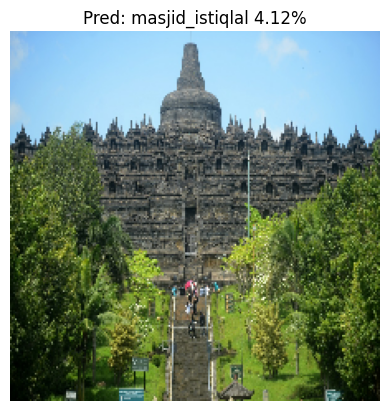

1/1 [==============================] - 0s 19ms/step


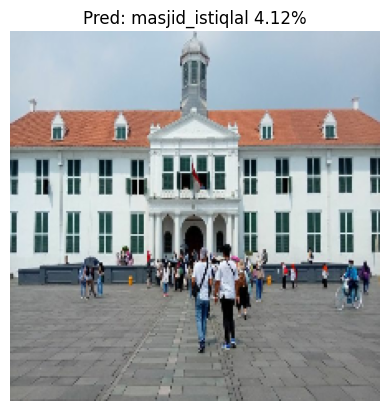

1/1 [==============================] - 0s 22ms/step


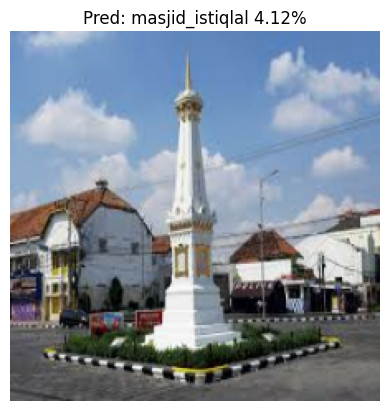

1/1 [==============================] - 0s 21ms/step


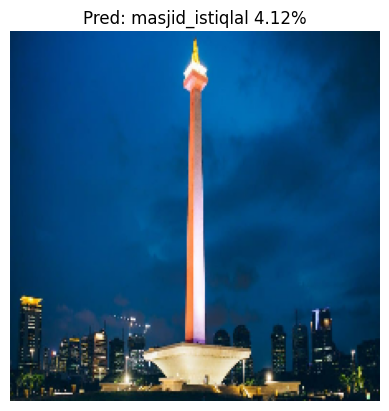

1/1 [==============================] - 0s 20ms/step


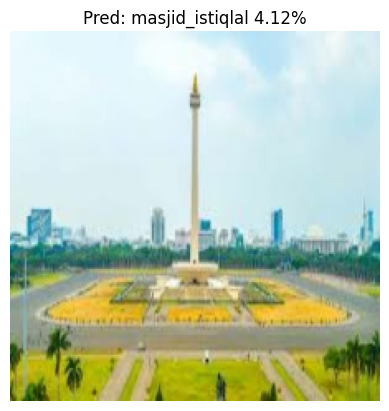

In [18]:
test_model(model_3)

## Model 4 - Fine-tuned on conv3, conv4, and conv5 layers."

In [19]:
img_shape = (IMG_SIZE, IMG_SIZE, 3)
base_model = DenseNet121(
    input_shape=img_shape,
    weights="imagenet",
    include_top=False,
    classes=25,
    classifier_activation="softmax"
)

img_shape

(224, 224, 3)

In [21]:
import re

inputs = tf.keras.Input(shape=img_shape)
x = data_augmentation(inputs)
x = base_model(x)
x = layers.AveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dropout(.1)(x)
x = layers.Dense(128, activation="relu")(x)
output = layers.Dense(25, activation="softmax")(x)

model_4 = Model(inputs=inputs, outputs=output, name="model_4_DenseNet121")

for layer in base_model.layers:
    if re.search(r"^conv[3|4|5].*", layer.name):
        layer.trainable = True
    else:
        layer.trainable = False

model_4.summary()

Model: "model_4_DenseNet121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 average_pooling2d_2 (Averag  (None, 3, 3, 1024)       0         
 ePooling2D)                                                     
                                                                 
 flatten_2 (Flatten)         (None, 9216)              0         
                                                                 
 dropout_2 (Dropout)         (None, 9216)              0         
                                               

In [22]:
for i, l in enumerate(base_model.layers):
    print(i, l.name, l.trainable)

0 input_3 False
1 zero_padding2d_2 False
2 conv1/conv False
3 conv1/bn False
4 conv1/relu False
5 zero_padding2d_3 False
6 pool1 False
7 conv2_block1_0_bn False
8 conv2_block1_0_relu False
9 conv2_block1_1_conv False
10 conv2_block1_1_bn False
11 conv2_block1_1_relu False
12 conv2_block1_2_conv False
13 conv2_block1_concat False
14 conv2_block2_0_bn False
15 conv2_block2_0_relu False
16 conv2_block2_1_conv False
17 conv2_block2_1_bn False
18 conv2_block2_1_relu False
19 conv2_block2_2_conv False
20 conv2_block2_concat False
21 conv2_block3_0_bn False
22 conv2_block3_0_relu False
23 conv2_block3_1_conv False
24 conv2_block3_1_bn False
25 conv2_block3_1_relu False
26 conv2_block3_2_conv False
27 conv2_block3_concat False
28 conv2_block4_0_bn False
29 conv2_block4_0_relu False
30 conv2_block4_1_conv False
31 conv2_block4_1_bn False
32 conv2_block4_1_relu False
33 conv2_block4_2_conv False
34 conv2_block4_concat False
35 conv2_block5_0_bn False
36 conv2_block5_0_relu False
37 conv2_block5_

In [23]:
model_4.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics=['accuracy'])

In [24]:
%%time
history_4 = model_4.fit(
    train_data,
    epochs=50,
    validation_data=val_data,
)

Epoch 1/50
92/92 [==============================] - 34s 228ms/step - loss: 3.2044 - accuracy: 0.1241 - val_loss: 3.1929 - val_accuracy: 0.1373
Epoch 2/50
92/92 [==============================] - 18s 176ms/step - loss: 2.4180 - accuracy: 0.3084 - val_loss: 23.7397 - val_accuracy: 0.0343
Epoch 3/50
92/92 [==============================] - 19s 186ms/step - loss: 1.8633 - accuracy: 0.4790 - val_loss: 3.9648 - val_accuracy: 0.3137
Epoch 4/50
92/92 [==============================] - 19s 189ms/step - loss: 1.4752 - accuracy: 0.5474 - val_loss: 1.4170 - val_accuracy: 0.6176
Epoch 5/50
92/92 [==============================] - 19s 191ms/step - loss: 1.1717 - accuracy: 0.6661 - val_loss: 1.4816 - val_accuracy: 0.6029
Epoch 6/50
92/92 [==============================] - 19s 192ms/step - loss: 0.8266 - accuracy: 0.7555 - val_loss: 1.4018 - val_accuracy: 0.6373
Epoch 7/50
92/92 [==============================] - 19s 191ms/step - loss: 0.7742 - accuracy: 0.7636 - val_loss: 1.3567 - val_accuracy: 0.583

In [25]:
model_4.save("history/model_DenseNet121_v2.h5")

## Plot history of model 4

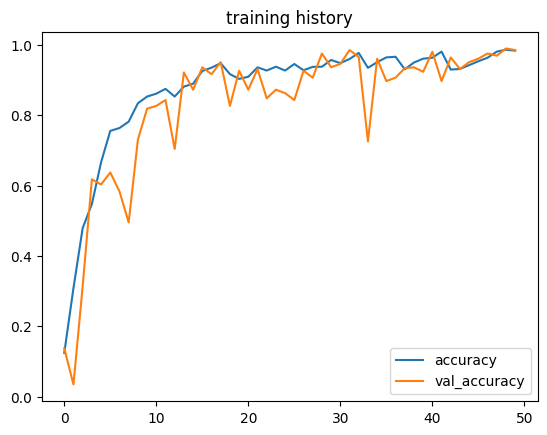

In [26]:
plot_history(model_history=history_4, seq_1="accuracy", seq_2="val_accuracy")

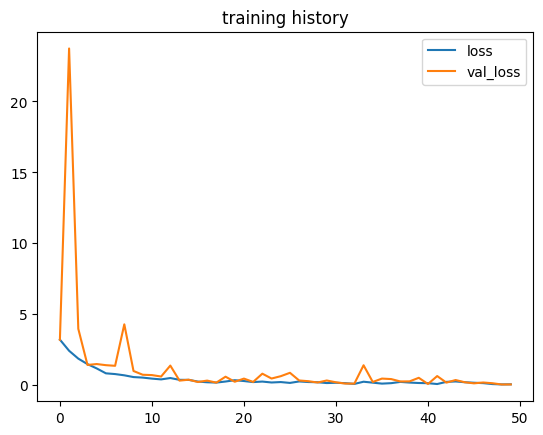

In [27]:
plot_history(model_history=history_4, seq_1="loss", seq_2="val_loss")

## Test model 4

1/1 [==============================] - 1s 991ms/step


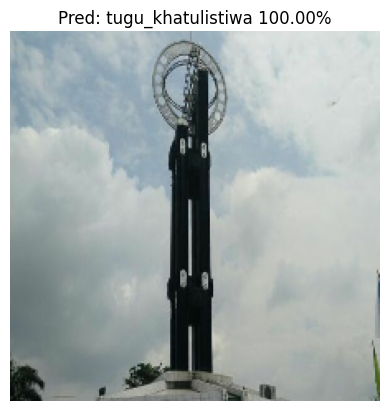

1/1 [==============================] - 0s 20ms/step


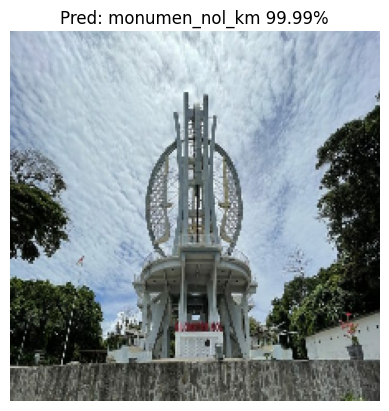

1/1 [==============================] - 0s 20ms/step


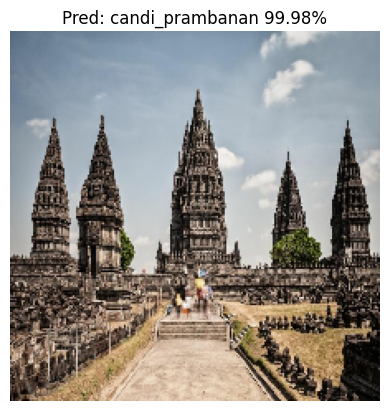

1/1 [==============================] - 0s 20ms/step


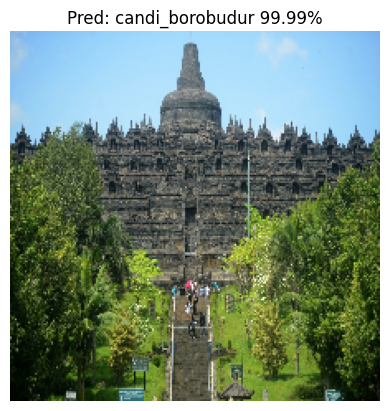

1/1 [==============================] - 0s 21ms/step


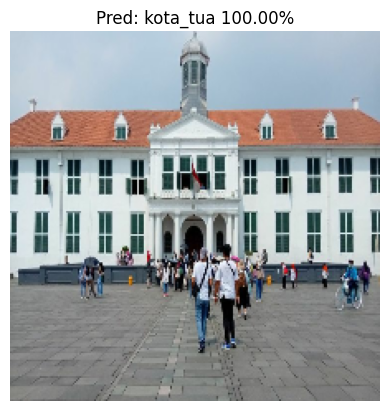

1/1 [==============================] - 0s 19ms/step


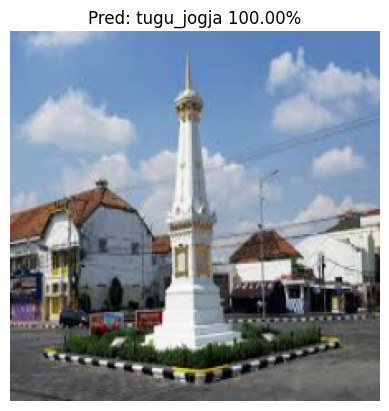

1/1 [==============================] - 0s 19ms/step


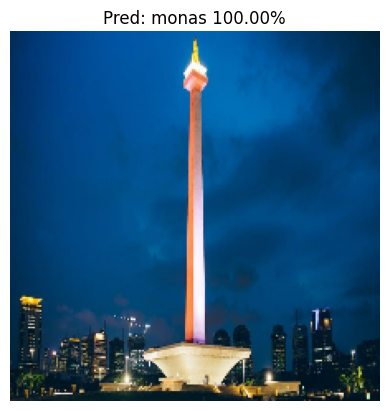

1/1 [==============================] - 0s 20ms/step


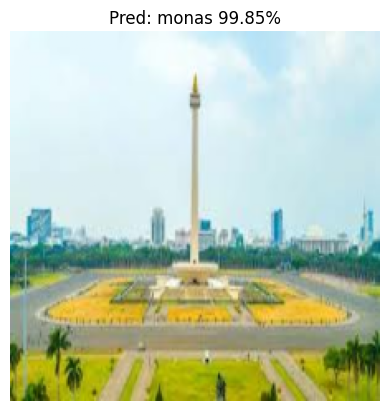

In [28]:
test_model(model_4)

## Model 5 - DenseNet121 fine-tuned on all conv layers

In [29]:
img_shape = (IMG_SIZE, IMG_SIZE, 3)
base_model = DenseNet121(
    input_shape=img_shape,
    weights="imagenet",
    include_top=False,
    classes=25,
    classifier_activation="softmax"
)

img_shape

(224, 224, 3)

In [30]:
inputs = tf.keras.Input(shape=img_shape)
x = data_augmentation(inputs)
x = base_model(x)
x = layers.AveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dropout(.1)(x)
x = layers.Dense(128, activation="relu")(x)
output = layers.Dense(25, activation="softmax")(x)

model_5 = Model(inputs=inputs, outputs=output, name="model_5_DenseNet121")

for layer in base_model.layers:
    if re.search(r"^conv.*", layer.name):
        layer.trainable = True
    else:
        layer.trainable = False

model_5.summary()

Model: "model_5_DenseNet121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 average_pooling2d_3 (Averag  (None, 3, 3, 1024)       0         
 ePooling2D)                                                     
                                                                 
 flatten_3 (Flatten)         (None, 9216)              0         
                                                                 
 dropout_3 (Dropout)         (None, 9216)              0         
                                               

In [32]:
for i, l in enumerate(base_model.layers):
    print(i, l.name, l.trainable)

0 input_6 False
1 zero_padding2d_4 False
2 conv1/conv True
3 conv1/bn True
4 conv1/relu True
5 zero_padding2d_5 False
6 pool1 False
7 conv2_block1_0_bn True
8 conv2_block1_0_relu True
9 conv2_block1_1_conv True
10 conv2_block1_1_bn True
11 conv2_block1_1_relu True
12 conv2_block1_2_conv True
13 conv2_block1_concat True
14 conv2_block2_0_bn True
15 conv2_block2_0_relu True
16 conv2_block2_1_conv True
17 conv2_block2_1_bn True
18 conv2_block2_1_relu True
19 conv2_block2_2_conv True
20 conv2_block2_concat True
21 conv2_block3_0_bn True
22 conv2_block3_0_relu True
23 conv2_block3_1_conv True
24 conv2_block3_1_bn True
25 conv2_block3_1_relu True
26 conv2_block3_2_conv True
27 conv2_block3_concat True
28 conv2_block4_0_bn True
29 conv2_block4_0_relu True
30 conv2_block4_1_conv True
31 conv2_block4_1_bn True
32 conv2_block4_1_relu True
33 conv2_block4_2_conv True
34 conv2_block4_concat True
35 conv2_block5_0_bn True
36 conv2_block5_0_relu True
37 conv2_block5_1_conv True
38 conv2_block5_1_bn 

In [33]:
model_5.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics=['accuracy'])

In [34]:
%%time
history_5 = model_5.fit(
    train_data,
    epochs=50,
    validation_data=val_data,
)

Epoch 1/50


2024-06-07 22:10:56.988232: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 958.38MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-07 22:10:56.988279: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 958.38MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-07 22:10:56.988299: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 958.38MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-07 22:10:57.070993: W tensorflow/core/common_runtime/bfc_al

18/92 [====>.........................] - ETA: 15s - loss: 3.8577 - accuracy: 0.0602

2024-06-07 22:11:01.970262: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 946.12MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


92/92 [==============================] - 33s 251ms/step - loss: 3.2578 - accuracy: 0.0903 - val_loss: 6.8265 - val_accuracy: 0.0588
Epoch 2/50
92/92 [==============================] - 23s 236ms/step - loss: 2.6365 - accuracy: 0.2226 - val_loss: 20.9387 - val_accuracy: 0.1029
Epoch 3/50
92/92 [==============================] - 24s 247ms/step - loss: 2.1682 - accuracy: 0.3650 - val_loss: 4.5166 - val_accuracy: 0.1373
Epoch 4/50
92/92 [==============================] - 24s 247ms/step - loss: 1.7595 - accuracy: 0.4781 - val_loss: 5.9905 - val_accuracy: 0.2304
Epoch 5/50
92/92 [==============================] - 24s 247ms/step - loss: 1.4492 - accuracy: 0.5584 - val_loss: 3.9158 - val_accuracy: 0.3673
Epoch 6/50
92/92 [==============================] - 25s 254ms/step - loss: 1.1927 - accuracy: 0.6515 - val_loss: 7.2018 - val_accuracy: 0.2206
Epoch 7/50
92/92 [==============================] - 25s 253ms/step - loss: 1.0252 - accuracy: 0.6743 - val_loss: 2.5571 - val_accuracy: 0.4902
Epoch 8/5

In [35]:
model_5.save("history/model_DenseNet121_v3.h5")

## Plot history of model 5

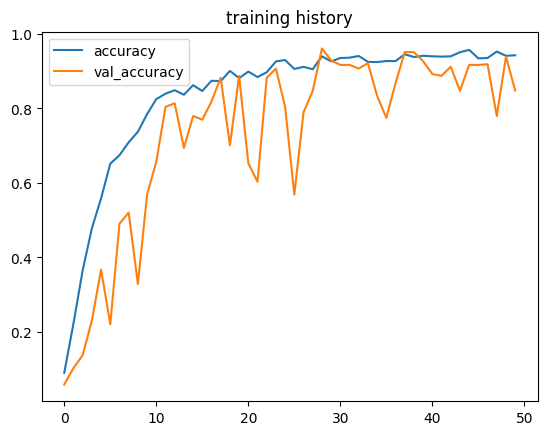

In [36]:
plot_history(model_history=history_5, seq_1="accuracy", seq_2="val_accuracy")

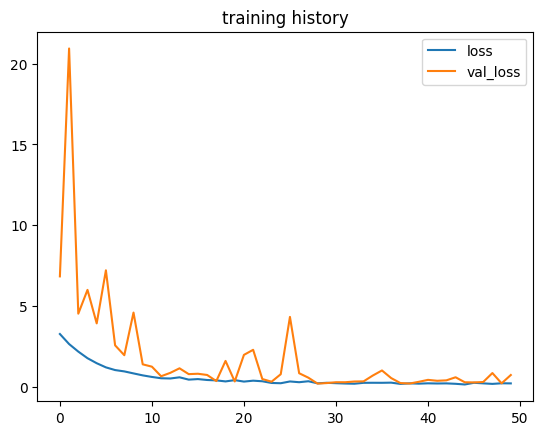

In [37]:
plot_history(model_history=history_5, seq_1="loss", seq_2="val_loss")

## Test model 5

1/1 [==============================] - 1s 1s/step


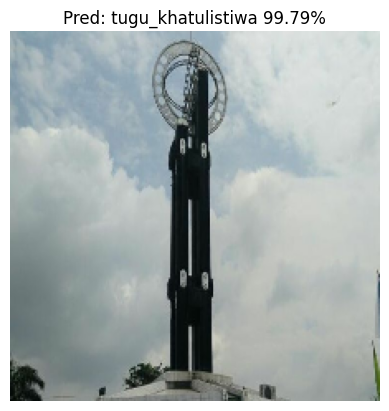

1/1 [==============================] - 0s 19ms/step


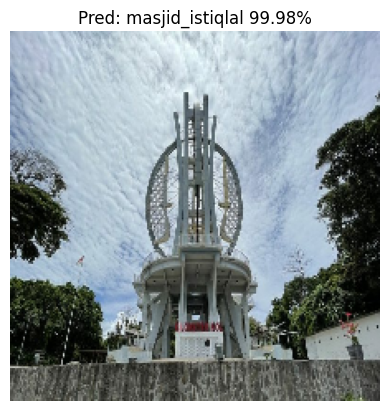

1/1 [==============================] - 0s 22ms/step


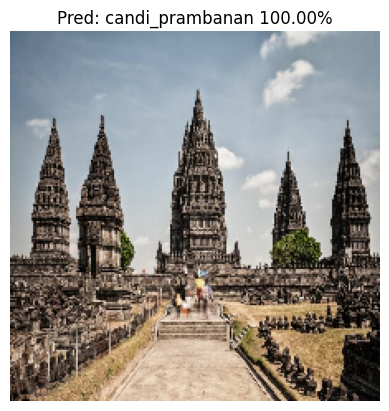

1/1 [==============================] - 0s 19ms/step


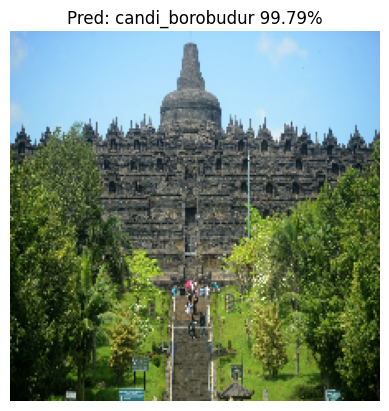

1/1 [==============================] - 0s 20ms/step


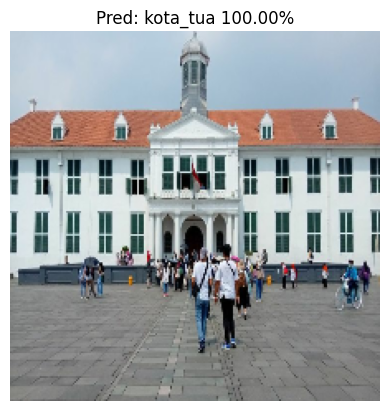

1/1 [==============================] - 0s 20ms/step


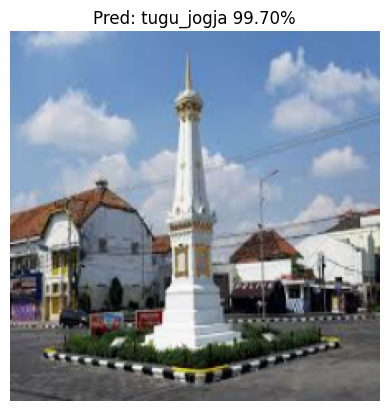

1/1 [==============================] - 0s 20ms/step


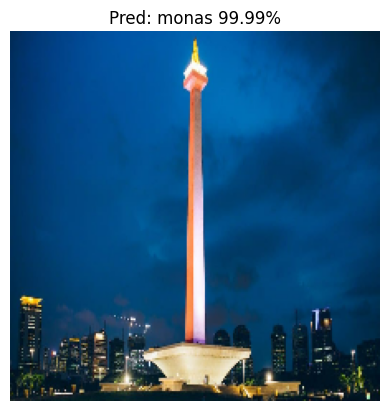

1/1 [==============================] - 0s 21ms/step


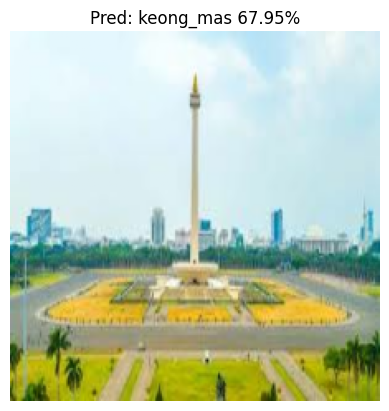

In [38]:
test_model(model_5)